## Installation

In [ ]:
!pip uninstall torch-scatter --y
!pip uninstall torch-sparse --y
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html

!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

Found existing installation: torch-scatter 2.0.8
Uninstalling torch-scatter-2.0.8:
  Successfully uninstalled torch-scatter-2.0.8
Found existing installation: torch-sparse 0.6.12
Uninstalling torch-sparse-0.6.12:
  Successfully uninstalled torch-sparse-0.6.12
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
  Using cached https://data.pyg.org/whl/torch-1.9.0%2Bcu111/torch_scatter-2.0.8-cp37-cp37m-linux_x86_64.whl (10.4 MB)
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
  Using cached https://data.pyg.org/whl/torch-1.9.0%2Bcu111/torch_sparse-0.6.12-cp37-cp37m-linux_x86_64.whl (3.7 MB)


In [ ]:
import torch_geometric
torch_geometric.__version__

'2.0.1'

## GNN Stack Module

Below is the implementation of a general GNN stack, where we can plugin any GNN layer, such as **GraphSage**, **GAT**, etc. This module is provided for you. Your implementations of the **GraphSage** and **GAT** layers will function as components in the GNNStack Module.

In [ ]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [ ]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.lin_l = nn.Linear(self.in_channels, self.out_channels)
        self.lin_r = nn.Linear(self.in_channels, self.out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        
        x_propagate = self.propagate(edge_index, x=(x, x), size=size)
        x = self.lin_l(x) + x_propagate

        if self.normalize:
            x = F.normalize(x)

        out = x
        return out

    def message(self, x_j):
        out = self.lin_r(x_j)
        return out

    def aggregate(self, inputs, index, dim_size = Non
        node_dim = self.node_dim
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean')


        return out


In [ ]:
## Graph Attention Network
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = nn.Linear(self.in_channels, self.heads * self.out_channels)

        self.lin_r = self.lin_l
        self.att_l = nn.Parameter(torch.randn(heads, self.out_channels))
        self.att_r = nn.Parameter(torch.randn(heads, self.out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels
        x_l = self.lin_l(x).view(-1, H, C) 
        x_r = self.lin_r(x).view(-1, H, C)

        alpha_l = self.att_l.unsqueeze(0) * x_l
        alpha_r = self.att_r.unsqueeze(0) * x_r

        out = self.propagate(edge_index, x = (x_l, x_r), alpha=(alpha_l, alpha_r))
        out = out.view(-1, H*C)

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        alpha_ij = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)

        if ptr is None:
            alpha_ij = softmax(alpha_ij, index)
        else:
            alpha_ij = softmax(alphaij, ptr)
        
        alpha_ij = F.dropout(alpha_ij, p=self.dropout)
        out = x_j * alpha_ij


        return out


    def aggregate(self, inputs, index, dim_size = None):

        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, reduce='sum')
    
        return out

In [ ]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [ ]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
    
    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 1000



Training: 100%|██████████| 500/500 [00:38<00:00, 12.90Epochs/s]


Maximum test set accuracy: 0.804
Minimum loss: 0.08533607423305511
Saving Model Predictions for Model Type GraphSage

Node task. test set size: 1000



Training: 100%|██████████| 500/500 [01:29<00:00,  5.56Epochs/s]


Maximum test set accuracy: 0.795
Minimum loss: 0.03139294311404228
Saving Model Predictions for Model Type GAT



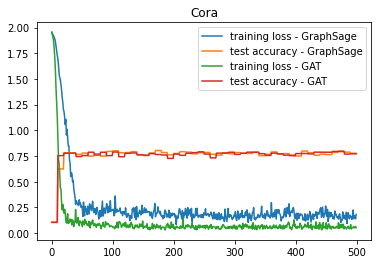

In [ ]:

for args in [
    {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
]:
    args = objectview(args)
    for model in ['GraphSage', 'GAT']:
        args.model_type = model

        # Match the dimension.
        if model == 'GAT':
          args.heads = 2
        else:
          args.heads = 1

        if args.dataset == 'cora':
            dataset = Planetoid(root='/tmp/cora', name='Cora')
        else:
            raise NotImplementedError("Unknown dataset") 
        test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 

        print("Maximum test set accuracy: {0}".format(max(test_accs)))
        print("Minimum loss: {0}".format(min(losses)))

        # Run test for our best model to save the predictions!
        test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
        print()

        plt.title(dataset.name)
        plt.plot(losses, label="training loss" + " - " + args.model_type)
        plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
    plt.legend()
    plt.show()
